# Imports

In [ ]:
!pip install simple-colors
!pip install scikit-plot
!wget https://raw.githubusercontent.com/LesiaR/Datasets-base/main/Cardiotocography.csv

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score, precision_score, average_precision_score, recall_score, make_scorer
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC, LinearSVC
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import matplotlib.cm as cm
import plotly.express as px
from sklearn import model_selection
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.spatial.distance import pdist, mahalanobis, squareform
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from simple_colors import *
import scikitplot as skplt

sns.set_style('darkgrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (5, 5)
warnings.filterwarnings('ignore')

# Data overview

Data set related to heart diseases. Normal patients are treated as inliers and the remaining as outliers, information is in outliers variable with yes/no values. The task is to detect outliers

In [ ]:
# Reading the data 
data = pd.read_csv('Cardiotocography.csv')

In [ ]:
# Checking datatypes of features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16880 entries, 0 to 16879
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        16880 non-null  float64
 1   LB        16880 non-null  float64
 2   AC        16880 non-null  float64
 3   FM        16880 non-null  float64
 4   UC        16880 non-null  float64
 5   ASTV      16880 non-null  float64
 6   MSTV      16880 non-null  float64
 7   ALTV      16880 non-null  float64
 8   MLTV      16880 non-null  float64
 9   DL        16880 non-null  float64
 10  DS        16880 non-null  float64
 11  DP        16880 non-null  float64
 12  Width     16880 non-null  float64
 13  Min       16880 non-null  float64
 14  Max       16880 non-null  float64
 15  Nmax      16880 non-null  float64
 16  Nzeros    16880 non-null  float64
 17  Mode      16880 non-null  float64
 18  Mean      16880 non-null  float64
 19  Median    16880 non-null  float64
 20  Variance  16880 non-null  fl

We can see that all dependant features are numerical

In [ ]:
# Checking length of ID feature to make sure it is not unique for every row
len(data.id.unique())

1902

In [ ]:
# Checking for duplicates
data.duplicated().sum()

0

In [ ]:
# Checking percentage of missing values for each feature
data.isna().sum()/len(data)

id          0.0
LB          0.0
AC          0.0
FM          0.0
UC          0.0
ASTV        0.0
MSTV        0.0
ALTV        0.0
MLTV        0.0
DL          0.0
DS          0.0
DP          0.0
Width       0.0
Min         0.0
Max         0.0
Nmax        0.0
Nzeros      0.0
Mode        0.0
Mean        0.0
Median      0.0
Variance    0.0
Tendency    0.0
outlier     0.0
dtype: float64

There are no duplicates or missing values in our dataset

# EDA, data preparation

Before exploring the data our target variable is replaced with numerical values and separate list for target and features X will be created

In [ ]:
# Replacing no values with 0 and yes values with 1
vals_to_replace = {"b'no'": 0, "b'yes'":1}
data.outlier = data.outlier.map(vals_to_replace)

In [ ]:
# Creating target and features list
target = 'outlier'
features = list(data.columns)
features.remove(target)

## Target

In [ ]:
# Checking percentage of outliers in dataset
data.outlier.value_counts(True)

0    0.98045
1    0.01955
Name: outlier, dtype: float64

Text(0.5, 1.0, 'Outliers distribution')

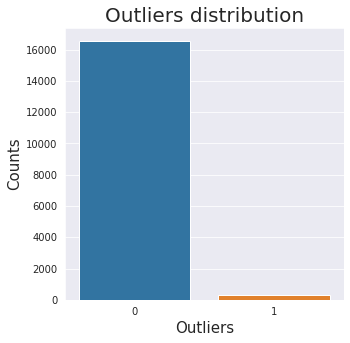

In [ ]:
# Visualization for target variable distribution
sns.countplot(data.outlier)
plt.xlabel('Outliers', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.title('Outliers distribution', fontsize=20)

* As we can see data is very unbalanced, and our target 1 (outlier) is minor class, represented with appr. 2% of data
* Some techniques for fixing balance can be used, but in real life it is correct nature of data, as anomalies should have small percentage in dataset

## X features

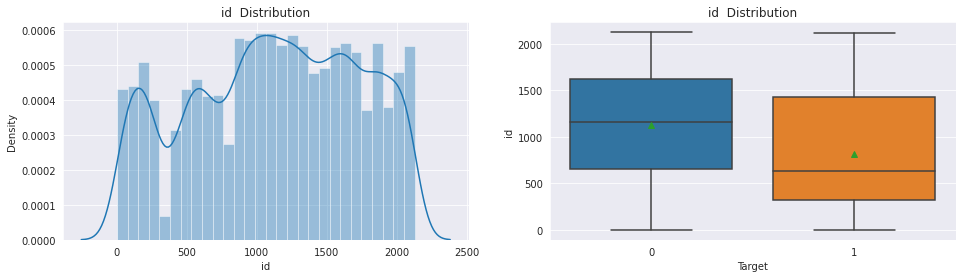

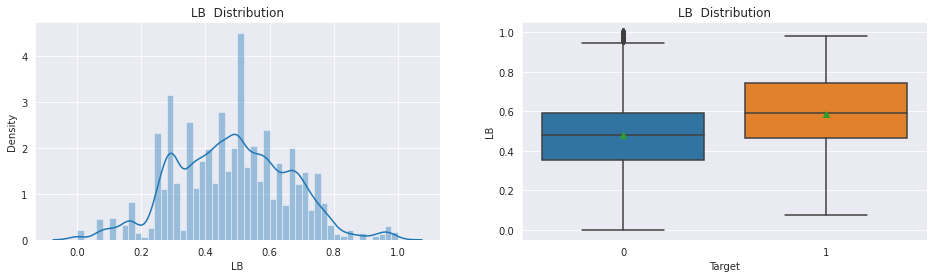

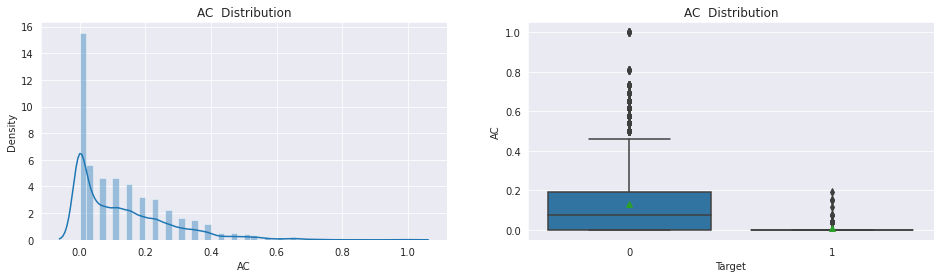

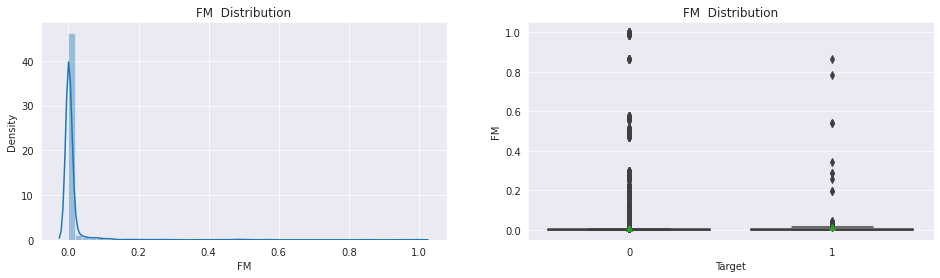

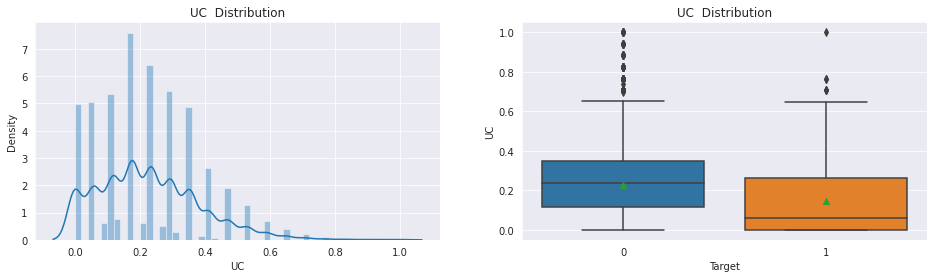

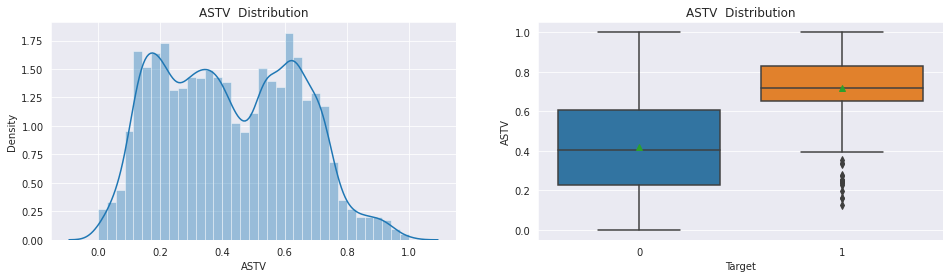

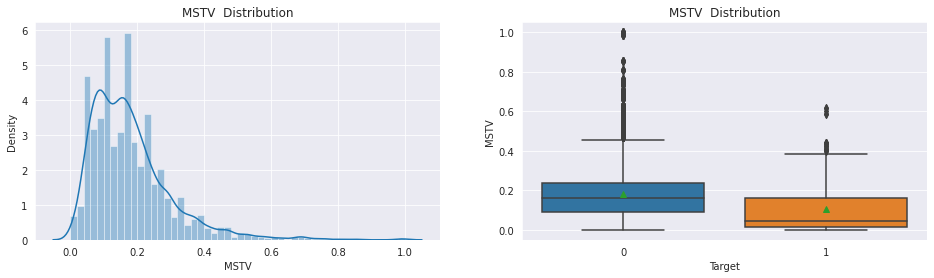

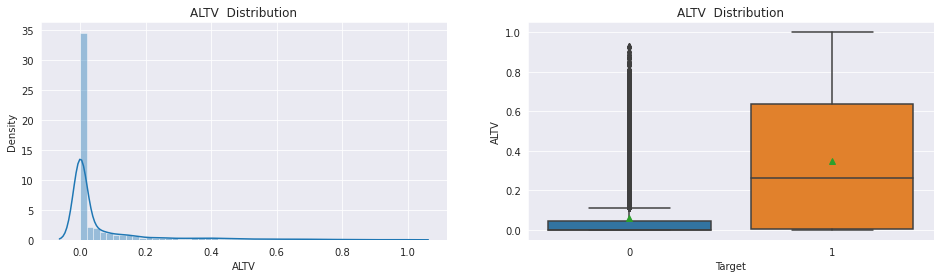

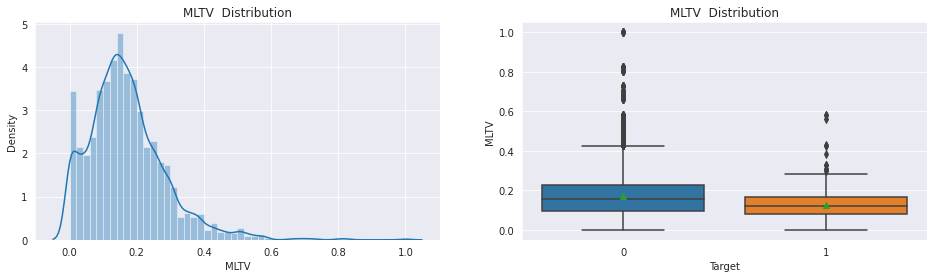

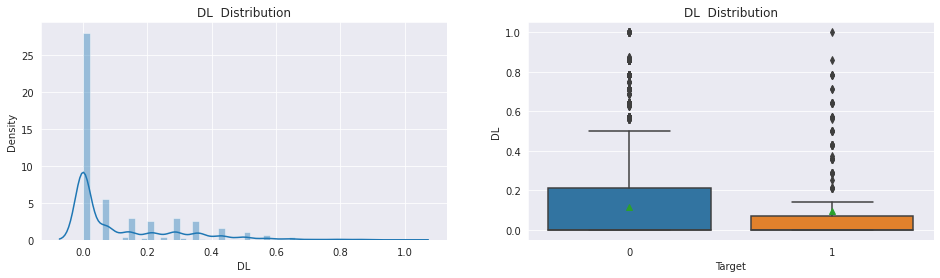

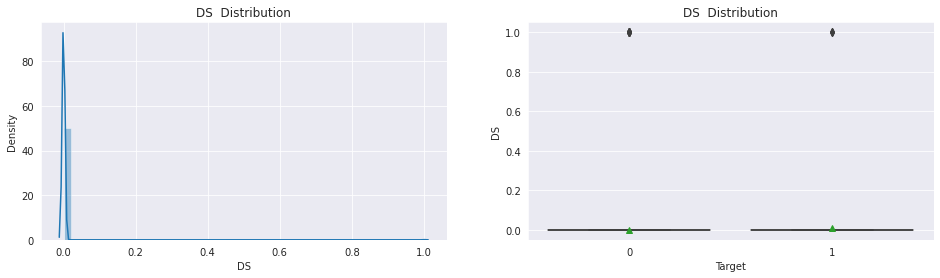

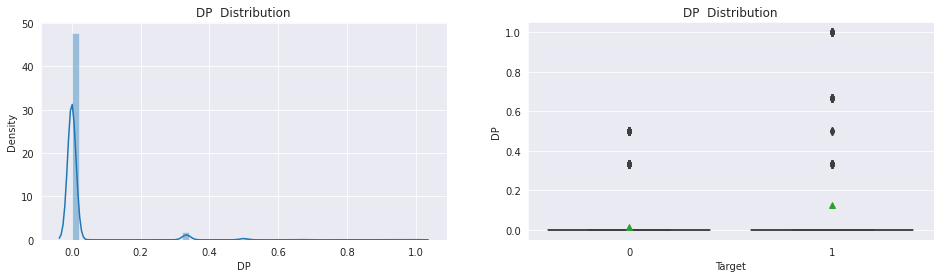

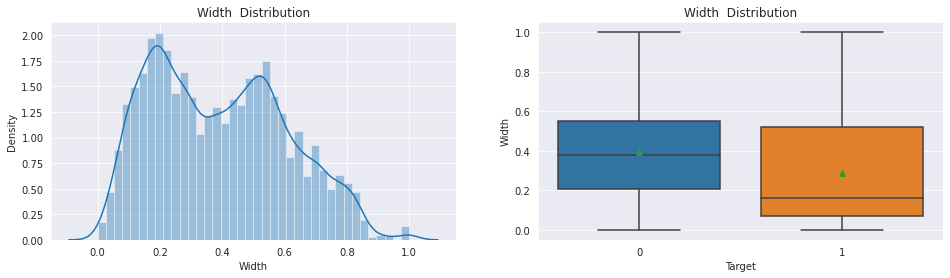

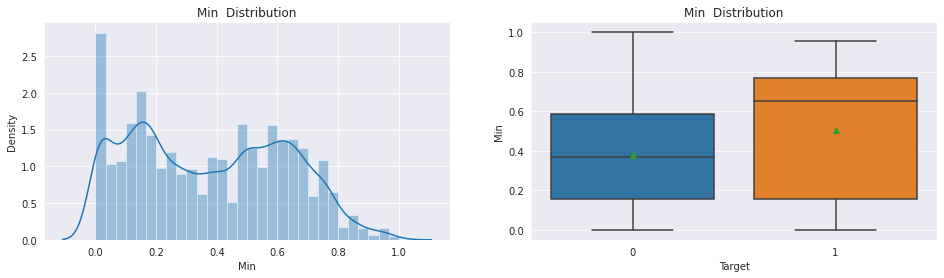

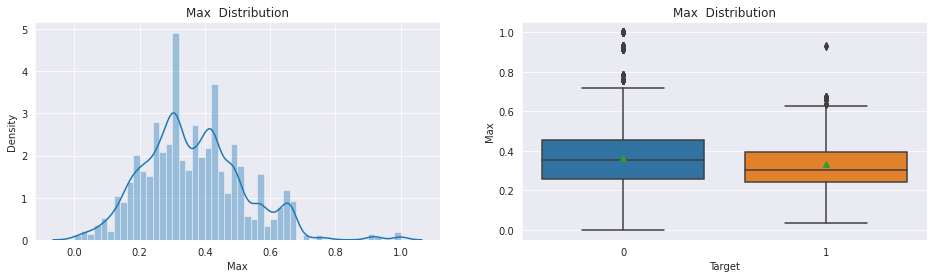

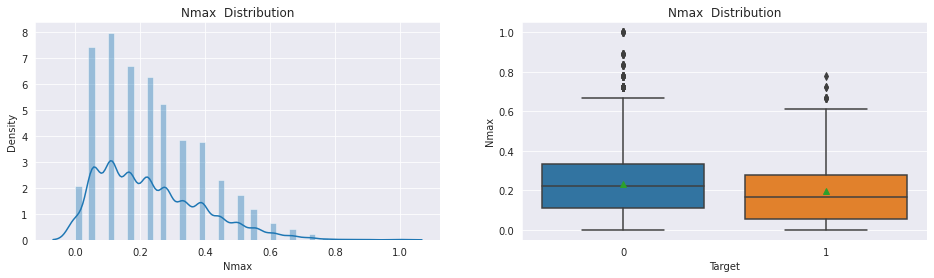

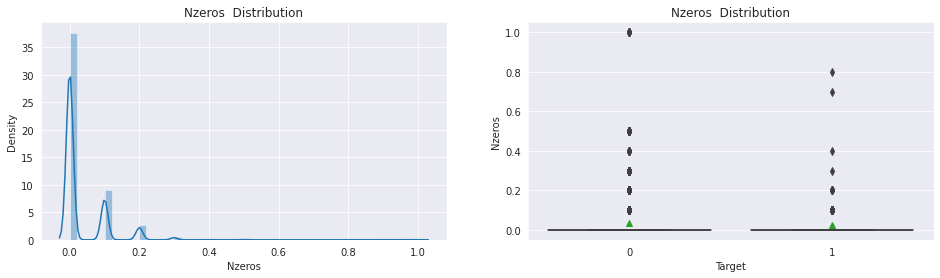

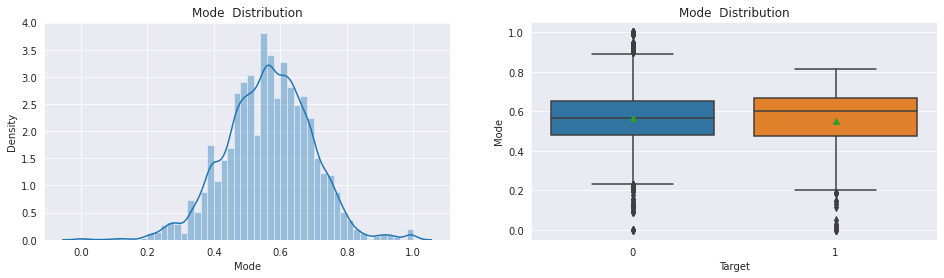

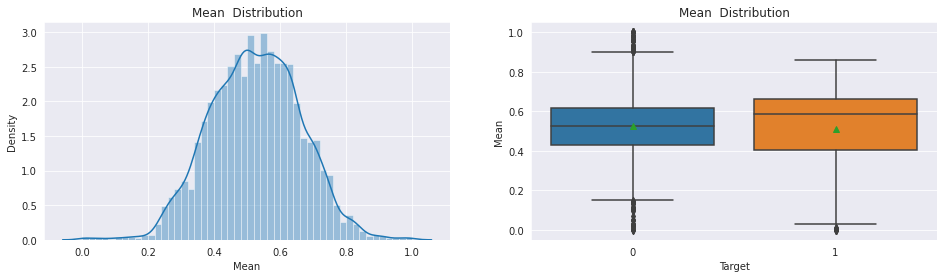

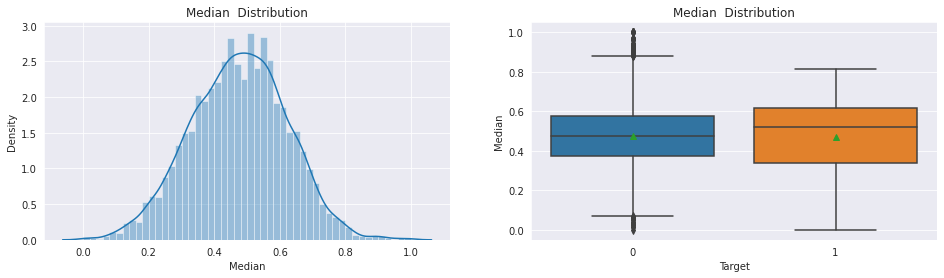

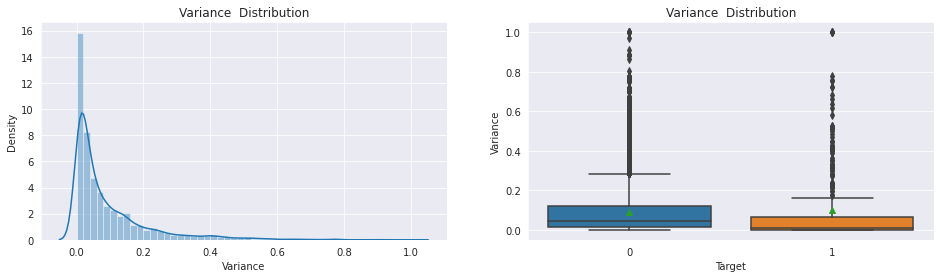

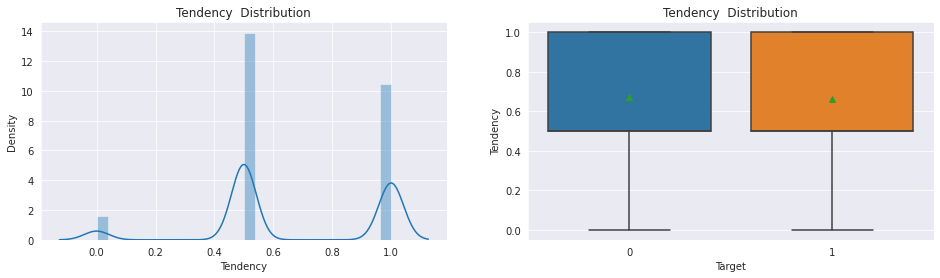

In [ ]:
# Visualization for numerical features distributions 

for feature in features:

    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1)
    sns.distplot(data[feature])
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.title(f'{feature}  Distribution')

    plt.subplot(1,2,2)
    sns.boxplot(x=target, y=feature, data=data, showmeans=True )
    plt.xlabel('Target')
    plt.ylabel(feature)
    plt.title(f'{feature}  Distribution');

* As we can see most of features are not normally distributed, some transformation will be done in next section
* Few features don't have any impact on target, they are the same for 1 and 0, so can be removed


In [ ]:
# Dropping features after analysis 
data.drop('FM', axis=1, inplace=True)
data.drop('DS', axis=1, inplace=True)
data.drop('DP', axis=1, inplace=True)
data.drop('Tendency', axis=1, inplace=True)

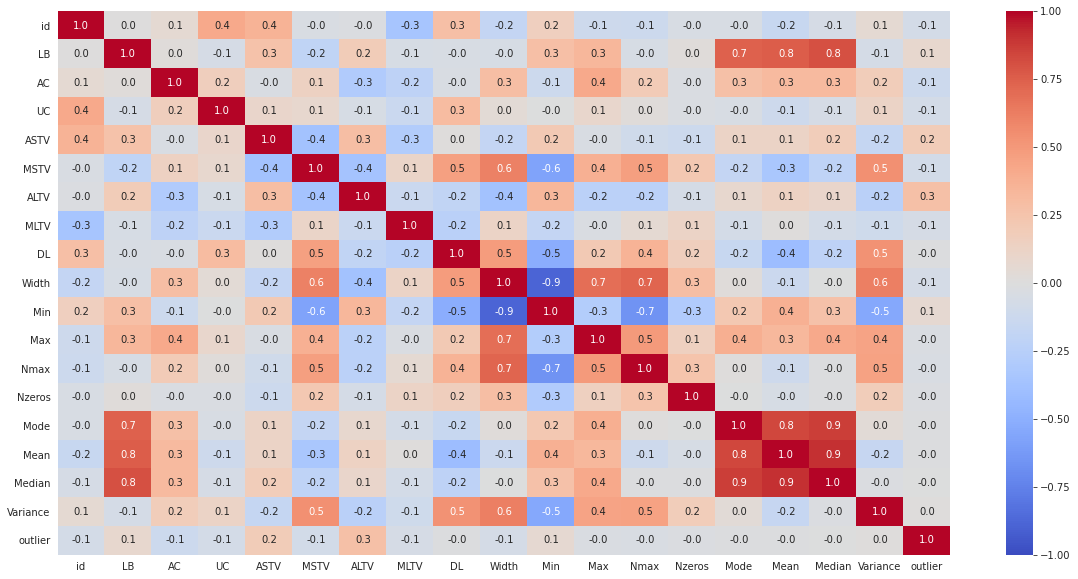

In [ ]:
# Checking correlation of numerical features in dataset
fig, ax = plt.subplots(figsize = (20, 10))
sns.heatmap(data.corr(), annot=True, fmt='.1f', vmin=-1, vmax=1, center= 0, cmap='coolwarm')

* From heatmap we can see that Mode, Mean and Median are positively highly correlated, and Min and Width are negatively highly correlated, that's why next 3 features will be dropped to avoid multicollinearity

In [ ]:
# Dropping features after correlation analysis 
data.drop('Mode', axis=1, inplace=True)
data.drop('Mean', axis=1, inplace=True)
data.drop('Min', axis=1, inplace=True)

# Feature transformation

* Our dataset doesn't have missing values so no imputation due to this is needed
* Target variable already was changed from string yes/no to binary 1/0 values
* For transformation log and squre root variants will be checked
* Scaling will be done with MinMaxScaler after that as our distributions are not normal

In [ ]:
# Separating x and y data
x_data = data.drop(target, axis=1)
y_data = data[target]

In [ ]:
# log and squre root transformation of data
log_df = np.log1p(x_data)
sqrt_df = np.sqrt(x_data)

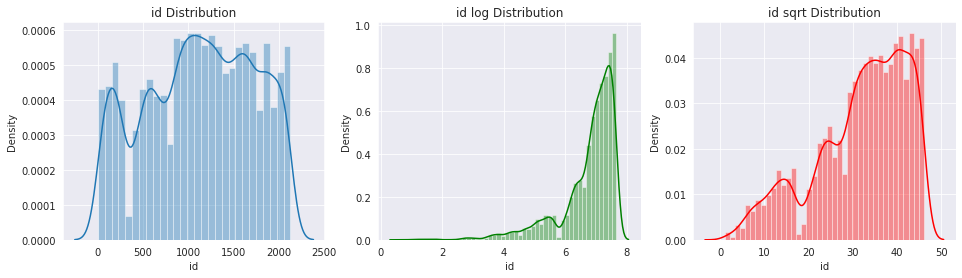

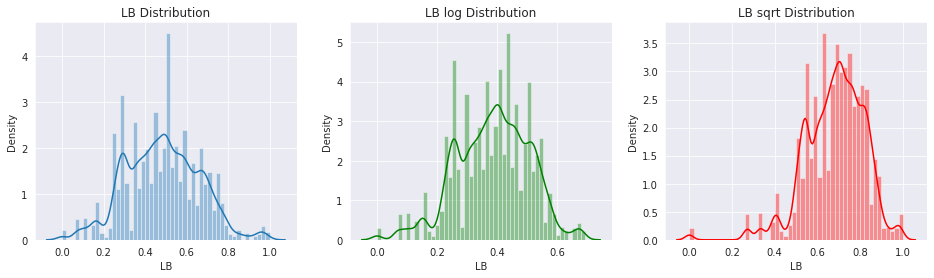

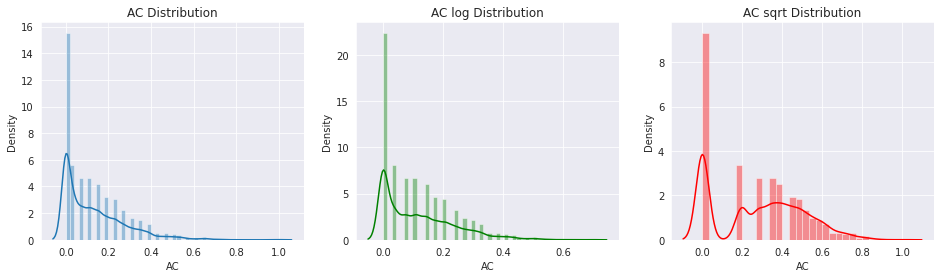

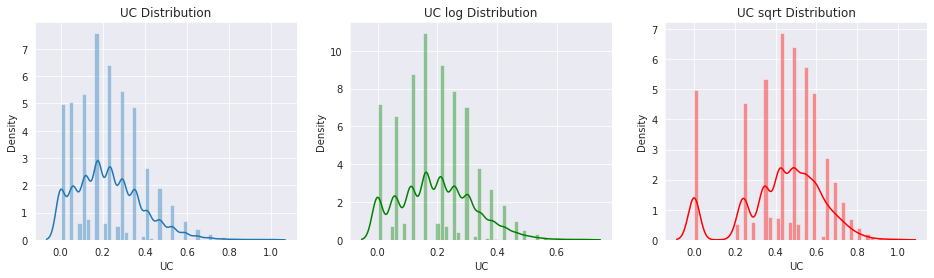

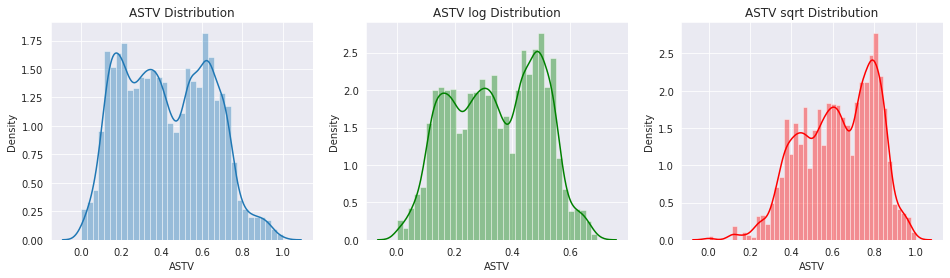

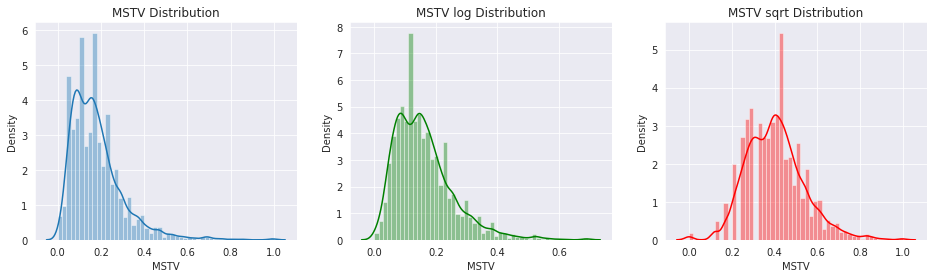

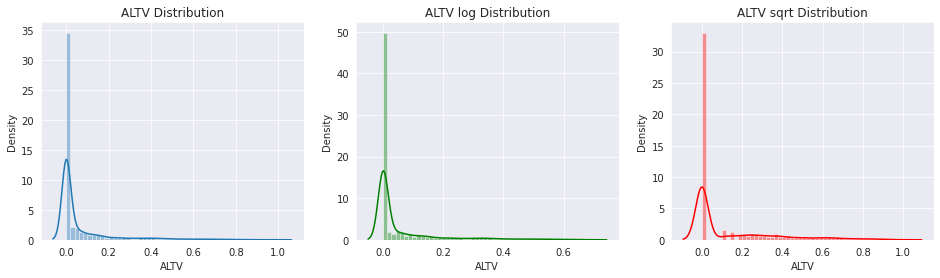

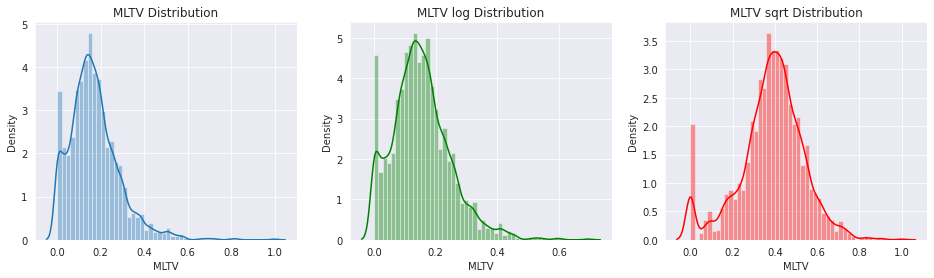

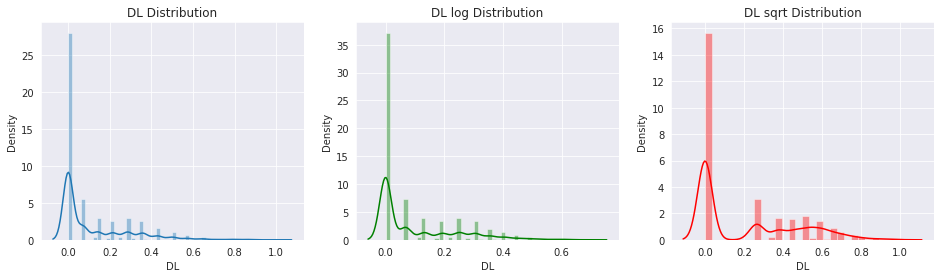

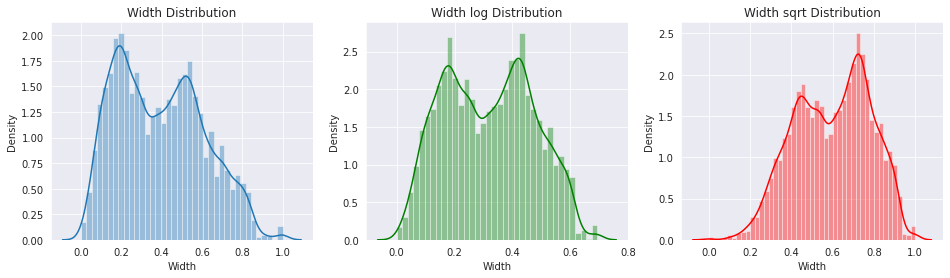

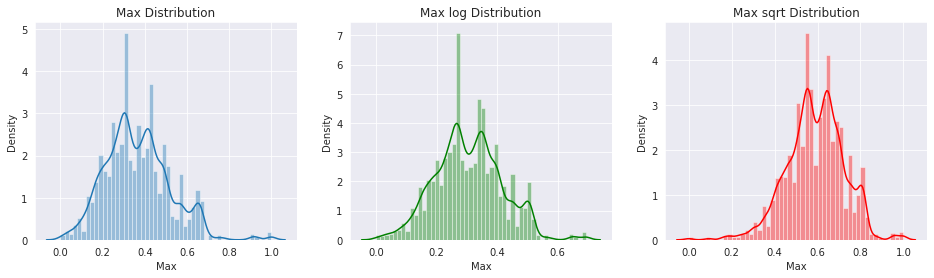

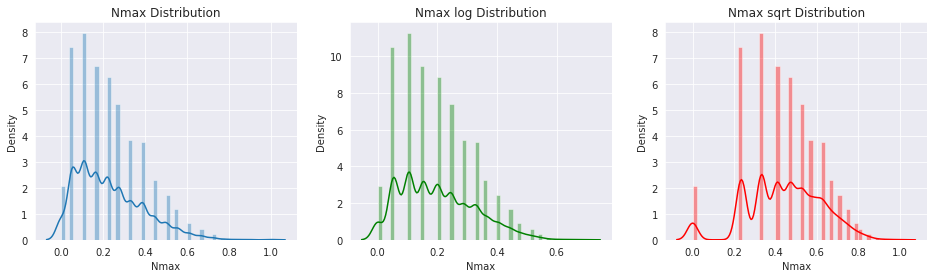

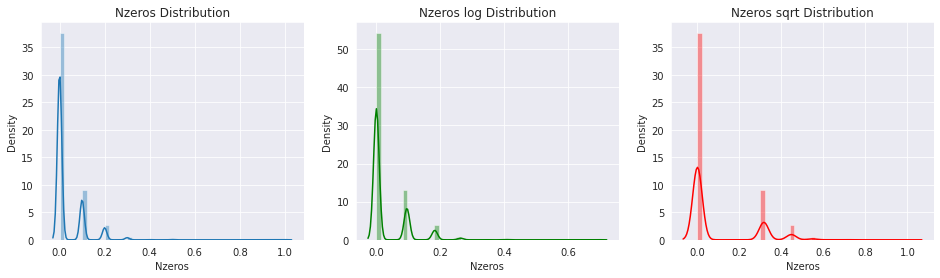

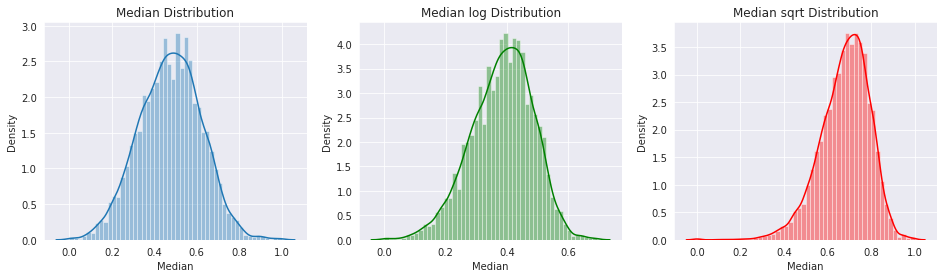

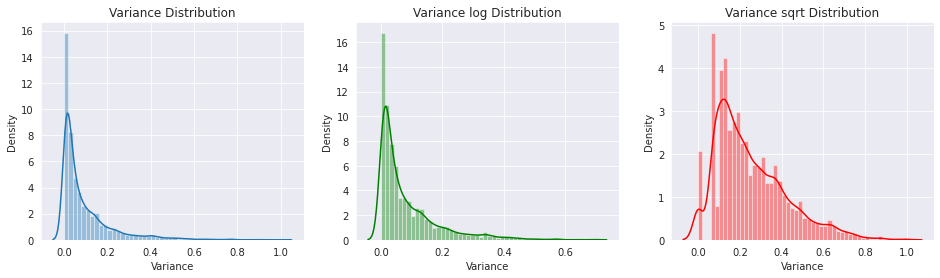

In [ ]:
# Visualization for features ditribution comparing after log and sqrt transformation
features_X = list(x_data.columns)
for feature in features_X:

    plt.figure(figsize=(16,4))
    plt.subplot(1,3,1)
    sns.distplot(data[feature])
    plt.xlabel(feature)
    plt.title(f'{feature} Distribution')

    plt.subplot(1,3,2)
    sns.distplot(log_df[feature], color='g')
    plt.xlabel(feature)
    plt.title(f'{feature} log Distribution')

    plt.subplot(1,3,3)
    sns.distplot(sqrt_df[feature], color='r')
    plt.xlabel(feature)
    plt.title(f'{feature} sqrt Distribution')

As we can see squre root transformation gave a little bit better result so it will be used in the future

In [ ]:
# Scaling with MinMaxScaler
sc = MinMaxScaler()
x_scaled = sc.fit_transform(sqrt_df)
x_scaled = pd.DataFrame(x_scaled)

# Dimentionality reduction

In [ ]:
# Dimentionality reduction with PCA to 2 dimentions
dim_reducer = PCA(n_components=2)
x_reduced = dim_reducer.fit_transform(x_scaled)
x_reduced.shape

(16880, 2)

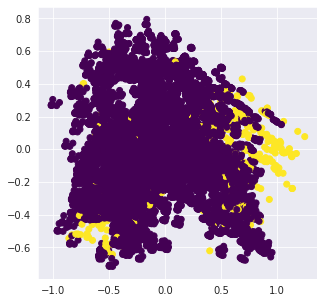

In [ ]:
# Visualization of data after PCA 
plt.scatter(x_reduced[:,0], x_reduced[:,1], c=y_data, cmap='viridis')

# Mahalanobis rule

In [ ]:
# Implementing mahalanobis rule and calculating distance for 2 points as an example
covariance_inverse = np.linalg.inv(np.cov(x_scaled.T))
codense = pdist(x_scaled, metric='mahalanobis', VI=covariance_inverse)
distance = squareform(codense)
distance[0, 20]

6.959965993709939

In [ ]:
# Calculating distances for all records
mean_vector = x_scaled.mean(axis=0)
bias_distance = x_scaled.apply(lambda row:
                             mahalanobis(mean_vector, row, VI=covariance_inverse), 
                             axis=1)
bias_distance.sort_values().tail(330)

3408      6.669568
1861      6.670850
3294      6.671518
4408      6.676196
10046     6.677445
           ...    
15220    10.646088
13535    11.553035
4606     11.564698
6758     12.529419
11825    13.197368
Length: 330, dtype: float64

Threshold was selected at 6.7 as we it corresponds to the last 330 distances appr. (we have such amount of outliers in dataset) 

In [ ]:
# Creating threshold at distance 6.7
predictions = np.zeros(x_scaled.shape[0])
predictions[bias_distance > 6.7] = 1

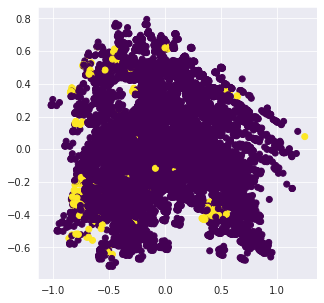

In [ ]:
# Visualization for mahalanobis rule
plt.scatter(x_reduced[:,0], x_reduced[:,1], c=predictions, cmap='viridis')

In [ ]:
# Classification report for mahalanobis rule
print(classification_report(y_data, predictions))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     16550
           1       0.14      0.14      0.14       330

    accuracy                           0.97     16880
   macro avg       0.56      0.56      0.56     16880
weighted avg       0.97      0.97      0.97     16880



For this task we care more about recall as we don't want to loose anomalies(outliers), also about f1 as detecting normal data is important too. In this case recall and f1 for minor class is not very good but will try to improve it in next section

# Supervised models

For supervised method as the metrics will be used classification report where the most important metrics will be f1 and recall, as we care more about finding outliers but still detecting normal data is also important.

Also for probabilities PR_ROC will be used as we have heavily imbalanced data.

In [ ]:
# Function for estimating model
def fit_est_model(X_tr, y_tr, X_ts, y_ts, model, title):
  model.fit(X_tr, y_tr)
  y_pred = model.predict(X_ts)
  y_pred_prob = model.predict_proba(X_ts)[:,1]
  print(red(title, ['bold']))
  print('PR_ROC:', blue(average_precision_score(y_ts, y_pred_prob), ['bold']))
  print('\nREPORT:\n', classification_report(y_pred, y_ts))
  return y_pred

In [ ]:
# Function for cross_validation of the model
def cross_validate(model, X_v, y_v, cv):
   scores = cross_val_score(model, X_v, y_v, scoring='f1', cv=cv)
   print('Cross-Validation F1 Scores:\n', scores)
   scores = pd.Series(scores)
   print('-------------------------------------------')
   print('Mean score: ', scores.mean())

In [ ]:
# Splitting into test and train sets
train_x, test_x, train_y, test_y = train_test_split(x_scaled, y_data, test_size = 0.20, shuffle=True, stratify=y_data)

## SVM

In [ ]:
# creating model instance
svc = CalibratedClassifierCV(LinearSVC(random_state=0))

In [ ]:
# Fitting and estimating the model
y_pred = fit_est_model(train_x, train_y, test_x, test_y, svc, 'LinearSVC')

LinearSVC
PR_ROC: 0.6094332568364058

REPORT:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      3350
           1       0.35      0.88      0.50        26

    accuracy                           0.99      3376
   macro avg       0.67      0.94      0.75      3376
weighted avg       0.99      0.99      0.99      3376



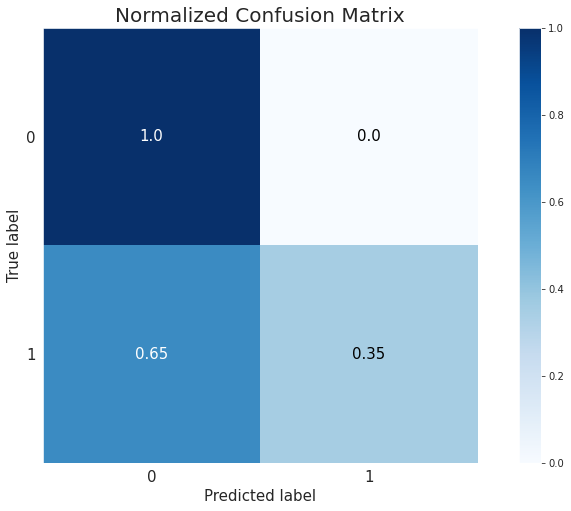

In [ ]:
# Confusion matrix for LinearSVM model
skplt.metrics.plot_confusion_matrix(test_y, y_pred, normalize=True, figsize=(15,8), title_fontsize=20, text_fontsize=15)
plt.show()

In [ ]:
# Cross-validation for the model
cross_validate(svc, test_x, test_y, 5)

Cross-Validation F1 Scores:
 [0.44444444 0.47058824 0.7        0.125      0.26666667]
-------------------------------------------
Mean score:  0.40133986928104576


## Logistic Regression

In [ ]:
# Logistic regression model with default regularization which is l2
lr = LogisticRegression(random_state=0)

In [ ]:
# Fitting and estimating the model
y_pred = fit_est_model(train_x, train_y, test_x, test_y, lr, 'LogReg')

LogReg
PR_ROC: 0.5790165006956243

REPORT:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      3363
           1       0.20      1.00      0.33        13

    accuracy                           0.98      3376
   macro avg       0.60      0.99      0.66      3376
weighted avg       1.00      0.98      0.99      3376



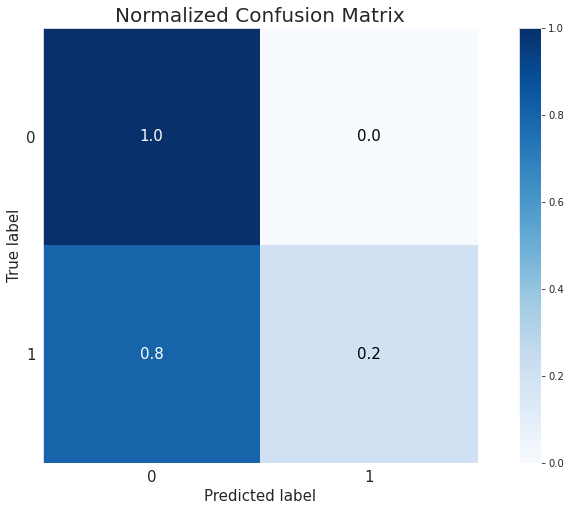

In [ ]:
# Confusion matrix for LogReg model
skplt.metrics.plot_confusion_matrix(test_y, y_pred, normalize=True, figsize=(15,8), title_fontsize=20, text_fontsize=15)
plt.show()

In [ ]:
# Cross-validation for the model
cross_validate(lr, test_x, test_y, 5)

Cross-Validation F1 Scores:
 [0.13333333 0.26666667 0.26666667 0.14285714 0.        ]
-------------------------------------------
Mean score:  0.16190476190476194


## KNN

First we need to find optimal value for n_neighbors

Minimum error: - 0.005627962085308057 at K = 1


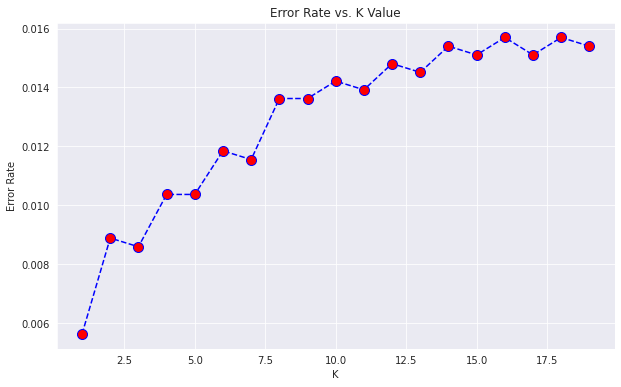

In [ ]:
# Calculating error between predicted and test values of y for different K
# Finding K-value for the smallest error
error_rate = []
for i in range(1,20):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(train_x, train_y)
 pred_i = knn.predict(test_x)
 error_rate.append(np.mean(pred_i != test_y))

plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error: -",min(error_rate),"at K =",error_rate.index(min(error_rate))+1)

In [ ]:
# KNN model with optimal 1 number of neighbors
knn = KNeighborsClassifier(n_neighbors = 1) 

In [ ]:
# Fitting and estimating the model
y_pred = fit_est_model(train_x, train_y, test_x, test_y, knn, 'KNN')

KNN
PR_ROC: 0.7177621802706433

REPORT:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      3327
           1       0.73      0.98      0.83        49

    accuracy                           0.99      3376
   macro avg       0.86      0.99      0.92      3376
weighted avg       1.00      0.99      0.99      3376



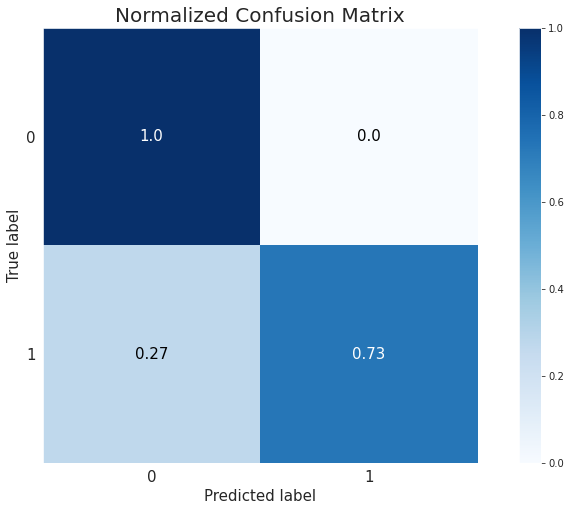

In [ ]:
# Confusion matrix for the KNN
skplt.metrics.plot_confusion_matrix(test_y, y_pred, normalize=True, figsize=(15,8), title_fontsize=20, text_fontsize=15)
plt.show()

In [ ]:
# Cross-validation for the model
cross_validate(knn, test_x, test_y, 5)

Cross-Validation F1 Scores:
 [0.52173913 0.44444444 0.72727273 0.45454545 0.47058824]
-------------------------------------------
Mean score:  0.5237179983983054


As we can see the best results among supervised models are for KNN, but also I'll try to improve it with some resampling

## Balancing the data

As our data is very unbalanced some resampling can be used for supervised models

In [ ]:
# Resampling X and y datasets with SMOTE technique
sm = SMOTE(k_neighbors=3, random_state=0)
X_sm, y_sm = sm.fit_resample(train_x, train_y)

In [ ]:
# Fitting models with resampled data and estimation results
fit_est_model(X_sm, y_sm, test_x, test_y, svc, 'LinearSVC')
fit_est_model(X_sm, y_sm, test_x, test_y, lr, 'LogReg')
fit_est_model(X_sm, y_sm, test_x, test_y, knn, 'KNN')

LinearSVC
PR_ROC: 0.5472589676857953

REPORT:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94      2964
           1       0.91      0.15      0.25       412

    accuracy                           0.89      3376
   macro avg       0.90      0.57      0.60      3376
weighted avg       0.90      0.89      0.86      3376

LogReg
PR_ROC: 0.5440442277373697

REPORT:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94      2959
           1       0.91      0.14      0.25       417

    accuracy                           0.89      3376
   macro avg       0.90      0.57      0.60      3376
weighted avg       0.89      0.89      0.86      3376

KNN
PR_ROC: 0.7920100823931787

REPORT:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3322
           1       0.80      0.98      0.88        54

    accuracy                           1.00      3

array([0, 0, 0, ..., 0, 0, 0])

## Conclusion:
* For supervised technique the best model is still KNN, and after fixing unbalanced data metrics showed even better results

# Unsupervised models

As a metrics main one will be f1 and recall so classification report will be used for this, but also visualization will be checked

In [ ]:
# Function for classification report 
def report(y_data, predictions):
  print(classification_report(y_data, predictions))

In [ ]:
# Function for changing outliers to -1 values/ inliers to 1 values
def repl_to_neg(y):
  y = y.copy()  
  y = y.replace(1, -1)
  y = y.replace(0, 1)
  return y

# Function for changing outliers to 1 values/ inliers to 0 values
def repl_to_pos(pred):
  pred = pd.DataFrame(pred) 
  pred = pred.replace(1, 0)
  pred = pred.replace(-1, 1)
  pred = np.array(pred[0])
  return pred

## Isolation Forest

For Isolation Forest first model with default hyperparameters was build, and then with grid search some hyperparameters were tuned

In [ ]:
# Building model with default hyperparameters
iso_forest = IsolationForest(random_state=0)
iso_predictions = iso_forest.fit_predict(x_scaled)
iso_predictions = repl_to_pos(iso_predictions)

Text(0.5, 1.0, 'Outliers visualization for basic IsolationForest')

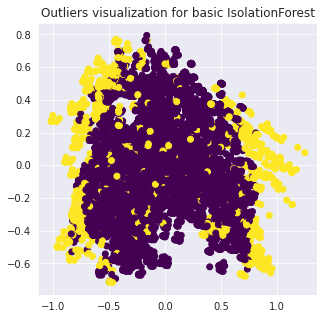

In [ ]:
# Visualization for default Isolation Forest model
plt.scatter(x_reduced[:,0], x_reduced[:,1], c=iso_predictions, cmap='viridis')
plt.title('Outliers visualization for basic IsolationForest')

In [ ]:
# Checking classification report for Isolation Forest model 
report(y_data, iso_predictions)

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     16550
           1       0.09      0.60      0.16       330

    accuracy                           0.88     16880
   macro avg       0.54      0.74      0.55     16880
weighted avg       0.97      0.88      0.92     16880



* As we can see from visualization and from report f1 and recall is not very high, so will try to improve
* In grid search f1 score was used because despite we are more interested in outliers detection but inliers correct classification is important as well


In [ ]:
# Creating GridSearch instance
param_grid = {'n_estimators': list(range(10, 100, 10)), 
              'contamination': [0.1, 0.2, 0.7, 0.9], 
              'max_features': [5,10,15], 
              'bootstrap': [True, False]}

grid_search_isof = GridSearchCV(estimator = iso_forest, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring='f1')

In [ ]:
# Converting outliers data to the corresponding to model output format
y_data1 = repl_to_neg(y_data)

In [ ]:
# Grid search for isolation forest model
%%time
grid_search_isof.fit(x_scaled, y_data1)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  3.7min finished


CPU times: user 5.61 s, sys: 605 ms, total: 6.21 s
Wall time: 3min 41s


GridSearchCV(cv=3, error_score=nan,
             estimator=IsolationForest(behaviour='deprecated', bootstrap=False,
                                       contamination='auto', max_features=1.0,
                                       max_samples='auto', n_estimators=100,
                                       n_jobs=None, random_state=0, verbose=0,
                                       warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'contamination': [0.1, 0.2, 0.7, 0.9],
                         'max_features': [5, 10, 15],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=2)

In [ ]:
# Best model
grid_search_isof.best_estimator_

IsolationForest(behaviour='deprecated', bootstrap=True, contamination=0.1,
                max_features=15, max_samples='auto', n_estimators=80,
                n_jobs=None, random_state=0, verbose=0, warm_start=False)

In [ ]:
# Building and fitting new best model with tuned hyperparameters
iso_forest = IsolationForest(behaviour='deprecated', bootstrap=True, contamination=0.1,
                max_features=15, max_samples='auto', n_estimators=80,
                n_jobs=None, random_state=0, verbose=0, warm_start=False)

iso_predictions = iso_forest.fit_predict(x_scaled)
iso_predictions = repl_to_pos(iso_predictions)

Text(0.5, 1.0, 'Outliers visualization for IsolationForest(tuned)')

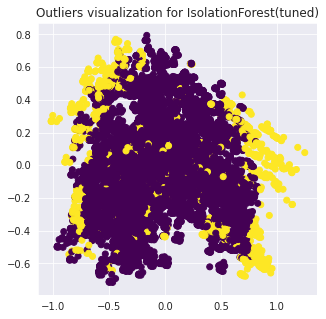

In [ ]:
# Visualization for tuned Isolation Forest model
plt.scatter(x_reduced[:,0], x_reduced[:,1], c=iso_predictions, cmap='viridis')
plt.title('Outliers visualization for IsolationForest(tuned)')

In [ ]:
# Checking metrics for Isolation Forest model after tuned hyperparameters
report(y_data, iso_predictions)

              precision    recall  f1-score   support

           0       0.99      0.91      0.95     16550
           1       0.10      0.53      0.17       330

    accuracy                           0.90     16880
   macro avg       0.55      0.72      0.56     16880
weighted avg       0.97      0.90      0.93     16880



* As we can see from the metrics f1 was improved a little bit

## One-Class SVM

With OneClassSVM I've tried first linear and precomputed kernels for model and then did more precise grid search.



In [ ]:
# Building basic OneClassSVM model with linear kernel
oc_svm = OneClassSVM(kernel='linear')
svm_predictions = oc_svm.fit_predict(x_scaled)
svm_predictions = repl_to_pos(svm_predictions)

Text(0.5, 1.0, 'Outliers visualization for OneClassSVM(linear)')

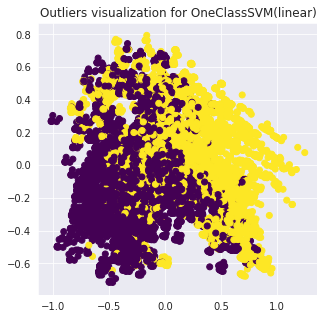

In [ ]:
# Visualization for basic OneClassSVM model with linear kernel
plt.scatter(x_reduced[:,0], x_reduced[:,1], c=svm_predictions, cmap='viridis')
plt.title('Outliers visualization for OneClassSVM(linear)')

In [ ]:
# Checking metrics for basic OneClassSVM model ith linear kernel
report(y_data, svm_predictions)

              precision    recall  f1-score   support

           0       0.99      0.50      0.67     16550
           1       0.03      0.71      0.05       330

    accuracy                           0.51     16880
   macro avg       0.51      0.61      0.36     16880
weighted avg       0.97      0.51      0.66     16880



As we can see f1 metrics are not the best, so let's check one more kernel

In [ ]:
# Building basic OneClassSVM model with precomputed kernel
oc_svm = OneClassSVM(kernel='precomputed')
svm_predictions = oc_svm.fit_predict(distance)
svm_predictions = repl_to_pos(svm_predictions)

Text(0.5, 1.0, 'Outliers visualization for OneClassSVM(precomputed)')

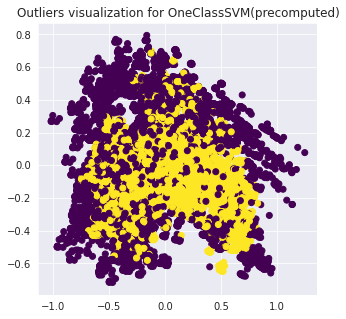

In [ ]:
# Visualization for basic OneClassSVM model
plt.scatter(x_reduced[:,0], x_reduced[:,1], c=svm_predictions, cmap='viridis')
plt.title('Outliers visualization for OneClassSVM(precomputed)')

In [ ]:
# Checking metrics for basic OneClassSVM model
report(y_data, svm_predictions)

              precision    recall  f1-score   support

           0       0.97      0.49      0.65     16550
           1       0.01      0.14      0.01       330

    accuracy                           0.49     16880
   macro avg       0.49      0.32      0.33     16880
weighted avg       0.95      0.49      0.64     16880



* We can see that metrics for f1 and recall are better for linear then for precomputed kernel
* For grid search all kernels except precomputed will be used





In [ ]:
# Creating GridSearch instance
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
              'nu': [0.02, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9], 
              'gamma': [0.01, 0.5, 0.8]}

oc_svm = OneClassSVM()

grid_search_oc_svm = GridSearchCV(estimator = oc_svm, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring='f1')

In [ ]:
# Converting outliers data to the corresponding model output format
y_data1 = repl_to_neg(y_data)

In [ ]:
%%time
grid_search_oc_svm.fit(x_scaled, y_data1)

Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 252 out of 252 | elapsed: 12.5min finished


CPU times: user 5.9 s, sys: 519 ms, total: 6.42 s
Wall time: 12min 28s


GridSearchCV(cv=3, error_score=nan,
             estimator=OneClassSVM(cache_size=200, coef0=0.0, degree=3,
                                   gamma='scale', kernel='rbf', max_iter=-1,
                                   nu=0.5, shrinking=True, tol=0.001,
                                   verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'gamma': [0.01, 0.5, 0.8],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'nu': [0.02, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=2)

In [ ]:
# Best model
grid_search_oc_svm.best_estimator_

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.01, kernel='rbf',
            max_iter=-1, nu=0.02, shrinking=True, tol=0.001, verbose=False)

In [ ]:
# Building and fitting new model with tuned hyperparameters
oc_svm = OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.01, kernel='rbf',
            max_iter=-1, nu=0.02, shrinking=True, tol=0.001, verbose=False)

svm_predictions = oc_svm.fit_predict(x_scaled)
svm_predictions = repl_to_pos(svm_predictions)

Text(0.5, 1.0, 'Outliers visualization for OneClassSVM(tuned)')

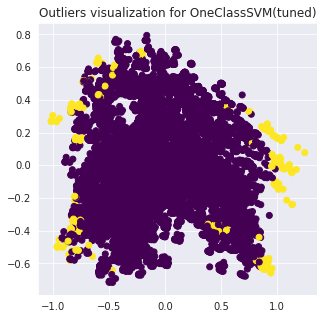

In [ ]:
# Visualization for tuned OneClassSVM model
plt.scatter(x_reduced[:,0], x_reduced[:,1], c=svm_predictions, cmap='viridis')
plt.title('Outliers visualization for OneClassSVM(tuned)')

In [ ]:
# Checking metrics for new OneClassSVM model
report(y_data, svm_predictions)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     16550
           1       0.20      0.20      0.20       330

    accuracy                           0.97     16880
   macro avg       0.59      0.59      0.59     16880
weighted avg       0.97      0.97      0.97     16880



As we can see f1 and recall score become better for minor class and visualization looks enough good. But still this model has smaller recall then Isolation Forest

## Conclusion:
From unsupervised models Isolation Forest gave better result and after hyperparameters tuning it was improved